## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [17]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [18]:
train, test = keras.datasets.cifar10.load_data()

In [19]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [20]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [21]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [22]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [23]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.3]
redice_lr_patient = [5, 3]

In [25]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience= reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
______________________________________________________________

Epoch 13/25
49/49 [==============================] - 3s 64ms/step - loss: 1.2286 - accuracy: 0.5730 - val_loss: 1.4734 - val_accuracy: 0.4769
Epoch 14/25
49/49 [==============================] - 3s 65ms/step - loss: 1.2029 - accuracy: 0.5826 - val_loss: 1.4727 - val_accuracy: 0.4803
Epoch 15/25
49/49 [==============================] - 4s 73ms/step - loss: 1.1776 - accuracy: 0.5932 - val_loss: 1.4648 - val_accuracy: 0.4878
Epoch 16/25
49/49 [==============================] - 4s 73ms/step - loss: 1.1538 - accuracy: 0.6028 - val_loss: 1.4553 - val_accuracy: 0.4829
Epoch 17/25
49/49 [==============================] - 3s 66ms/step - loss: 1.1309 - accuracy: 0.6098 - val_loss: 1.4576 - val_accuracy: 0.4842
Epoch 18/25
49/49 [==============================] - 4s 77ms/step - loss: 1.1070 - accuracy: 0.6199 - val_loss: 1.4460 - val_accuracy: 0.4887
Epoch 19/25
49/49 [==============================] - 4s 85ms/step - loss: 1.0851 - accuracy: 0.6283 - val_loss: 1.4625 - val_accuracy: 0.4862
Epoch 

Epoch 1/25
49/49 [==============================] - 5s 96ms/step - loss: 2.3299 - accuracy: 0.2422 - val_loss: 2.1678 - val_accuracy: 0.1892
Epoch 2/25
49/49 [==============================] - 3s 69ms/step - loss: 1.8713 - accuracy: 0.3565 - val_loss: 2.0332 - val_accuracy: 0.2608
Epoch 3/25
49/49 [==============================] - 3s 67ms/step - loss: 1.7270 - accuracy: 0.4027 - val_loss: 1.9076 - val_accuracy: 0.3277
Epoch 4/25
49/49 [==============================] - 3s 70ms/step - loss: 1.6467 - accuracy: 0.4295 - val_loss: 1.8082 - val_accuracy: 0.3618
Epoch 5/25
49/49 [==============================] - 3s 66ms/step - loss: 1.5912 - accuracy: 0.4471 - val_loss: 1.7178 - val_accuracy: 0.3958
Epoch 6/25
49/49 [==============================] - 4s 73ms/step - loss: 1.5470 - accuracy: 0.4636 - val_loss: 1.6530 - val_accuracy: 0.4203
Epoch 7/25
49/49 [==============================] - 3s 69ms/step - loss: 1.5104 - accuracy: 0.4763 - val_loss: 1.6156 - val_accuracy: 0.4315
Epoch 8/25
49

Epoch 22/25
49/49 [==============================] - 4s 72ms/step - loss: 0.4430 - accuracy: 0.8674 - val_loss: 1.5776 - val_accuracy: 0.5119
Epoch 23/25
49/49 [==============================] - 4s 77ms/step - loss: 0.4046 - accuracy: 0.8855 - val_loss: 1.6545 - val_accuracy: 0.5059
Epoch 24/25
49/49 [==============================] - 3s 67ms/step - loss: 0.3816 - accuracy: 0.8933 - val_loss: 1.7195 - val_accuracy: 0.4948
Epoch 25/25
49/49 [==============================] - 3s 66ms/step - loss: 0.3675 - accuracy: 0.8971 - val_loss: 1.6927 - val_accuracy: 0.5084
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 3
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_____________________

49/49 [==============================] - 4s 77ms/step - loss: 1.5309 - accuracy: 0.4642 - val_loss: 1.7313 - val_accuracy: 0.3953
Epoch 5/25
49/49 [==============================] - 4s 73ms/step - loss: 1.4866 - accuracy: 0.4808 - val_loss: 1.6667 - val_accuracy: 0.4171
Epoch 6/25
49/49 [==============================] - 3s 71ms/step - loss: 1.4492 - accuracy: 0.4954 - val_loss: 1.6193 - val_accuracy: 0.4333
Epoch 7/25
49/49 [==============================] - 3s 71ms/step - loss: 1.4203 - accuracy: 0.5063 - val_loss: 1.5758 - val_accuracy: 0.4486
Epoch 8/25
49/49 [==============================] - 3s 68ms/step - loss: 1.3930 - accuracy: 0.5170 - val_loss: 1.5492 - val_accuracy: 0.4577
Epoch 9/25
49/49 [==============================] - 4s 74ms/step - loss: 1.3686 - accuracy: 0.5253 - val_loss: 1.5443 - val_accuracy: 0.4560
Epoch 10/25
49/49 [==============================] - 4s 78ms/step - loss: 1.3469 - accuracy: 0.5344 - val_loss: 1.5332 - val_accuracy: 0.4654
Epoch 11/25
49/49 [====

Epoch 1/25
49/49 [==============================] - 4s 85ms/step - loss: 1.7950 - accuracy: 0.3777 - val_loss: 2.0136 - val_accuracy: 0.2690
Epoch 2/25
49/49 [==============================] - 4s 73ms/step - loss: 1.5288 - accuracy: 0.4603 - val_loss: 2.2614 - val_accuracy: 0.2718
Epoch 3/25
49/49 [==============================] - 4s 77ms/step - loss: 1.4251 - accuracy: 0.4956 - val_loss: 1.9893 - val_accuracy: 0.3108
Epoch 4/25
49/49 [==============================] - 4s 87ms/step - loss: 1.3583 - accuracy: 0.5193 - val_loss: 1.9496 - val_accuracy: 0.3491
Epoch 5/25
49/49 [==============================] - 4s 84ms/step - loss: 1.2956 - accuracy: 0.5441 - val_loss: 2.5157 - val_accuracy: 0.2613
Epoch 6/25
49/49 [==============================] - 4s 83ms/step - loss: 1.2398 - accuracy: 0.5633 - val_loss: 1.8732 - val_accuracy: 0.3639
Epoch 7/25
49/49 [==============================] - 4s 80ms/step - loss: 1.2052 - accuracy: 0.5755 - val_loss: 2.1570 - val_accuracy: 0.2922
Epoch 8/25
49

Epoch 20/25
49/49 [==============================] - 4s 73ms/step - loss: 0.7081 - accuracy: 0.7732 - val_loss: 1.4590 - val_accuracy: 0.5146
Epoch 21/25
49/49 [==============================] - 4s 76ms/step - loss: 0.6850 - accuracy: 0.7817 - val_loss: 1.5549 - val_accuracy: 0.4750
Epoch 22/25
49/49 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.7892
Epoch 00022: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
49/49 [==============================] - 4s 82ms/step - loss: 0.6656 - accuracy: 0.7892 - val_loss: 1.5259 - val_accuracy: 0.4876
Epoch 23/25
49/49 [==============================] - 4s 86ms/step - loss: 0.6083 - accuracy: 0.8160 - val_loss: 1.4507 - val_accuracy: 0.5185
Epoch 24/25
49/49 [==============================] - 4s 77ms/step - loss: 0.5914 - accuracy: 0.8228 - val_loss: 1.4695 - val_accuracy: 0.5110
Epoch 25/25
49/49 [==============================] - ETA: 0s - loss: 0.5785 - accuracy: 0.8294
Epoch 00025: ReduceLROnPlateau re

49/49 [==============================] - 4s 76ms/step - loss: 1.6383 - accuracy: 0.4311 - val_loss: 1.7625 - val_accuracy: 0.3944
Epoch 5/25
49/49 [==============================] - 4s 72ms/step - loss: 1.5776 - accuracy: 0.4521 - val_loss: 1.7051 - val_accuracy: 0.4135
Epoch 6/25
49/49 [==============================] - 4s 72ms/step - loss: 1.5274 - accuracy: 0.4698 - val_loss: 1.6400 - val_accuracy: 0.4279
Epoch 7/25
49/49 [==============================] - 4s 81ms/step - loss: 1.4848 - accuracy: 0.4852 - val_loss: 1.6090 - val_accuracy: 0.4361
Epoch 8/25
49/49 [==============================] - 4s 91ms/step - loss: 1.4479 - accuracy: 0.4993 - val_loss: 1.5814 - val_accuracy: 0.4509
Epoch 9/25
49/49 [==============================] - 5s 95ms/step - loss: 1.4135 - accuracy: 0.5101 - val_loss: 1.5799 - val_accuracy: 0.4432
Epoch 10/25
49/49 [==============================] - 5s 100ms/step - loss: 1.3828 - accuracy: 0.5218 - val_loss: 1.5598 - val_accuracy: 0.4491
Epoch 11/25
49/49 [===

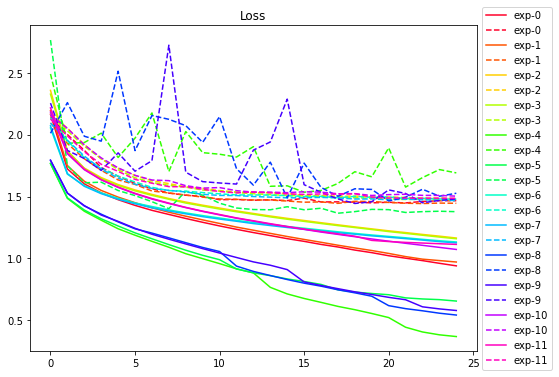

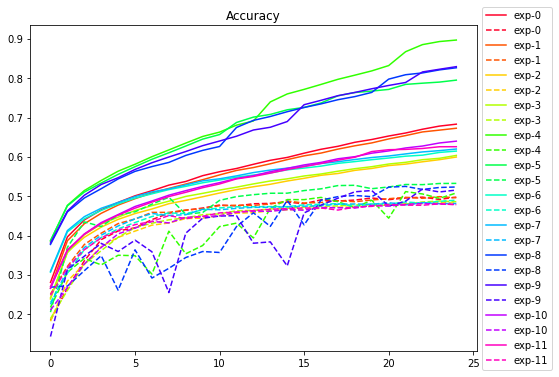

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()